In [42]:
import pandas as pd
from pprint import pprint as pp
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Exploratory Data Analysis

# Data Cleaning and Pre-Processing

In [3]:
#loading the data and check how does it look like
crowdstorming_df = pd.read_csv('CrowdstormingDataJuly1st.csv')
crowdstorming_df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
crowdstorming_df.shape

(146028, 28)

In [5]:
#crowdstorming_df.describe()
crowdstorming_df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID           True
rater1            True
rater2            True
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

From the description, we can conclude the following:
* There are missing values on rater1, rater2 and photoID and since our goal is to build a classifier based on those labels we decided to drop rows with nan values for those columns. 
* There are missing values in height, weight. A tentative solution is to replace those values by average heights and weights of people who belong to the same leagueCountry or people with same position (for e.g: goalkeeper is usually taller), but it is safe to do it and we don't have a lot of missing values. So, we decided to drop them.
* There are missing values for Alpha_3, meanIAT, nIAT, seIAT, meanExp, nExp, seExp. Those we also decided to drop.

In [6]:
crowdstorming_df = crowdstorming_df.dropna()

## Aggregating player-referee information by player

In [7]:
f = {'club':'first',
     'leagueCountry':'first',
     'birthday':'first',
     'height':'first', 
     'weight':'first',
     'games': 'sum', 
     'victories':'sum',
     'ties': 'sum',
     'defeats': 'sum', 
     'goals': 'sum', 
     'yellowCards': 'sum', 
     'yellowReds': 'sum', 
     'redCards': 'sum',
     'photoID':'first',
     'position':'first',
     'refNum':'first',
     'refCountry':'first',
     'Alpha_3':'first',
     'meanIAT':'mean',
     'nIAT':'mean', 
     'seIAT':'mean',
     'meanExp': 'mean',
     'nExp':'mean', 
     'seExp':'mean',
     'rater1':'mean',
     'rater2':'mean'
    }
crowdstorming_df_player_agg = crowdstorming_df.groupby(['playerShort']).agg(f)

# Encoding Categorical to Numerical Values

Since we want to use RandomForest Classifier, we need to convert all columns with categorical values into numerical values. Let's check for the categorical features:

In [8]:
crowdstorming_df_player_agg.dtypes

seIAT            float64
games              int64
position          object
refNum             int64
birthday          object
victories          int64
yellowCards        int64
rater2           float64
goals              int64
ties               int64
redCards           int64
height           float64
leagueCountry     object
refCountry         int64
weight           float64
photoID           object
Alpha_3           object
meanExp          float64
seExp            float64
defeats            int64
nExp             float64
nIAT             float64
yellowReds         int64
rater1           float64
meanIAT          float64
club              object
dtype: object

From the description above, the set of categorical features include:
* club
* leagueCountry
* birthday 
* position 
* Alpha_3

In [9]:
le = preprocessing.LabelEncoder()

crowdstorming_df_num = crowdstorming_df_player_agg 

# Converting club String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['club'])))
crowdstorming_df_num['club'] = le.transform(crowdstorming_df_player_agg['club']) 


# Converting leagueCountry String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['leagueCountry'])))
crowdstorming_df_num['leagueCountry'] = le.transform(crowdstorming_df_player_agg['leagueCountry']) 

# Converting birthday String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['birthday'])))
crowdstorming_df_num['birthday'] = le.transform(crowdstorming_df_player_agg['birthday']) 


# Converting position String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['position'])))
crowdstorming_df_num['position'] = le.transform(crowdstorming_df_player_agg['position']) 

# Converting position String to numerical representation
le.fit(list(set(crowdstorming_df_player_agg['Alpha_3'])))
crowdstorming_df_num['Alpha_3'] = le.transform(crowdstorming_df_player_agg['Alpha_3']) 

## Binary & Multi-Class Classification Labels

In [10]:
# Averaging over rater1 and rater2: 
crowdstorming_df_num['meanRating'] = (crowdstorming_df_num['rater1'] + crowdstorming_df_num['rater2'])/2
# Create Categories for Binary Classification
def binaryColor(x):
    if x < 0.5: 
        return 0
    else: 
        return 1
crowdstorming_df_num['BinaryColorClass'] = crowdstorming_df_num['meanRating'].apply(binaryColor) 

# Create Categories for Multi Classification
def multiColor(x):
    if x < 0.25: 
        return 0
    elif 0.25 <= x <0.5: 
        return 1
    elif 0.5 <= x < 0.75:
        return 2
    elif 0.75 <= x <= 1:
        return 3
crowdstorming_df_num['MultiColorClass'] = crowdstorming_df_num['meanRating'].apply(multiColor) 

In [21]:
features_player = ['weight', 'nExp', 'height', 'meanExp', 'yellowReds',
       'leagueCountry', 'club', 'victories', 'seExp', 'Alpha_3',
       'yellowCards', 'nIAT', 'birthday', 'goals', 'ties',
       'defeats','games','position', 'redCards']
features_referee = ['meanIAT', 'refCountry', 'refNum', 'seIAT']
X = crowdstorming_df_num [features_player]
y_binary = crowdstorming_df_num ['BinaryColorClass']
y_multi = crowdstorming_df_num ['MultiColorClass']

# 1. Supervised Learning

## 1.1. Binary Classification

In this section, we are building a classifer that can predict the skin color of the player, so let's have a look at the skin color distribution.

In [30]:
crowdstorming_df_num['BinaryColorClass'].value_counts()

0    1089
1     330
Name: BinaryColorClass, dtype: int64

Clearly we have a imbalance issue here! we should keep this point in oue mind for later analysis and model evaluation.. 

### Splitting data into train and test

In [12]:
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X,y_binary, test_size=0.3)

In [13]:
# Fit a random forest to the training data for binary classification, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier() # , class_weight='balanced')

forest_binary = forest.fit(X_train, y_train_binary) #, sample_weight= sample_weights)

Let's calculate the accuracy score for train binary classification 

In [14]:
from sklearn import metrics
result_binary_train = forest_binary.predict(X_train)
print(metrics.accuracy_score(y_train_binary, result_binary_train))

0.982880161128


In [15]:
from sklearn import metrics
result_binary_train = forest_binary.predict(X_train)
print(metrics.f1_score(y_train_binary, result_binary_train))

0.961968680089


Let's calculate the accuracy score for test binary classification

In [16]:
from sklearn import metrics
result_binary_test = forest_binary.predict(X_test)
print(metrics.accuracy_score(y_test_binary, result_binary_test))

0.798122065728


In [17]:
from sklearn import metrics
result_binary_test = forest_binary.predict(X_test)
print(metrics.f1_score(y_test_binary, result_binary_test))

0.385714285714


In [18]:
from sklearn import metrics
result_binary_test = forest_binary.predict(X_test)
print(metrics.precision_score(y_test_binary, result_binary_test))

0.642857142857


In [19]:
from __future__ import division
def area_under_curve (y_train,y_pred):
    N = len(y_train) 
    pos_train = 0
    neg_train = 0
    for i in range(1,N):
        if y_train[i] == 0: 
            neg_train = neg_train + 1
    
    pos_train = N - neg_train
    pos_pred = 0
    neg_pred = 0
    for j in range(1,N):
        if y_pred[i]==1:
            neg_pred = neg_pred + 1
        else:
            pos_pred = pos_pred + 1
    balanced_error_rate = (1/2) * ((pos_train/(pos_train+pos_pred)) + (neg_train/(neg_train+neg_pred)))
    return 1-balanced_error_rate

In [20]:
area_under_curve (y_test_binary, result_binary_test)

0.4055343511450382

In [33]:
cm=metrics.confusion_matrix(y_test_binary, result_binary_test)

In [34]:
print(cm)

[[313  15]
 [ 71  27]]


In [45]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

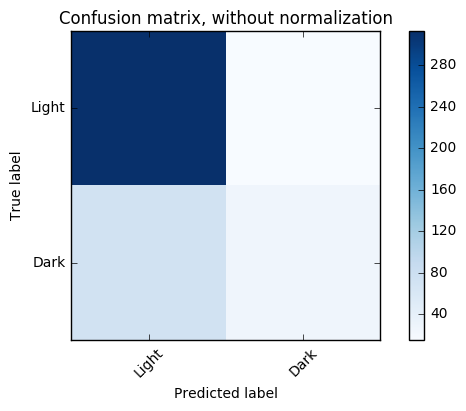

In [46]:
plot_confusion_matrix(cm, classes=['Light','Dark'],
                      title='Confusion matrix, without normalization')

From the confusion matrix above we see that the classifier does a good job in predicting light color skin plyers but the performance is really poor when it comes to predicitng plyers with dark skin color!

### K-Fold Cross Validation

In [21]:
from sklearn.cross_validation import cross_val_score
forest_binary = forest.fit(X_train, y_train_binary) #, sample_weight= sample_weights)
scores_binary = cross_val_score(forest_binary,  X, y_binary, cv=10, scoring='accuracy')
scores_binary.mean()

/home/meryem/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.78225951453401255

## Choosing the parameters of the model

(10, 'trees')
('score', 0.7857606632704025)
(30, 'trees')
('score', 0.79634402157626616)
(50, 'trees')
('score', 0.79562980721206678)
(100, 'trees')
('score', 0.79634901608230946)
(200, 'trees')
('score', 0.81114274298271916)
(500, 'trees')
('score', 0.80268204974528012)
(1000, 'trees')
('score', 0.80339126960343632)
(2000, 'trees')
('score', 0.80479472580161815)


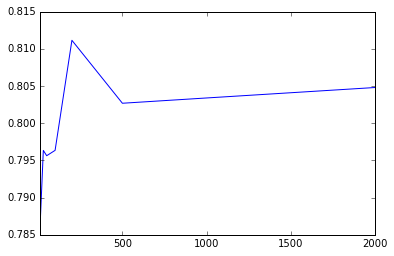

In [22]:
results=[]
n_estimator_options=[10,30,50,100,200,500,1000,2000]

for trees in n_estimator_options:
    model = RandomForestClassifier(n_estimators=trees)
    scores_binary = cross_val_score(model,  X, y_binary, cv=10, scoring='accuracy')
    print(trees,'trees')
    print('score', scores_binary.mean())
    results.append(scores_binary.mean())
pd.Series(results, n_estimator_options).plot()

(1, 'min_samples')
('score', 0.78719408650484468)
(2, 'min_samples')
('score', 0.78082609129957048)
(3, 'min_samples')
('score', 0.78858755369094002)
(4, 'min_samples')
('score', 0.77943262411347525)
(5, 'min_samples')
('score', 0.79141444411147743)
(6, 'min_samples')
('score', 0.79280291679152926)
(7, 'min_samples')
('score', 0.78998601538307844)
(8, 'min_samples')
('score', 0.79421636200179802)
(9, 'min_samples')
('score', 0.79139946059334743)
(10, 'min_samples')
('score', 0.78434721806013374)


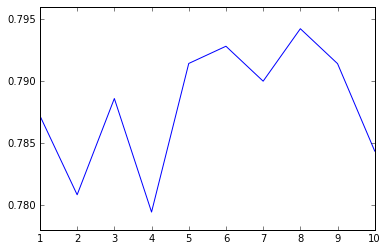

In [23]:
results=[]
min_samples_leaf_options=[1,2,3,4,5,6,7,8,9,10]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(min_samples_leaf=min_samples)
    scores_binary = cross_val_score(model,  X, y_binary, cv=10, scoring='accuracy')
    print(min_samples,'min_samples')
    print('score', scores_binary.mean())
    results.append(scores_binary.mean())
pd.Series(results, min_samples_leaf_options).plot()

In [24]:
model = RandomForestClassifier(n_estimators=1000, min_samples_leaf=6)
forest_binary = model.fit(X_train, y_train_binary) #, sample_weight= sample_weights)
scores_binary = cross_val_score(forest_binary,  X, y_binary, cv=10, scoring='accuracy')
scores_binary.mean()

0.80056437918289869

/home/meryem/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


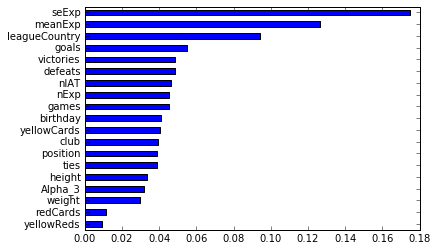

In [25]:
feature_importance= pd.Series(model.feature_importances_,index=X.columns)
feature_importance.sort()
feature_importance.plot(kind='barh')

## Bonus Part

In [26]:
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve
import numpy as np

In [27]:
def plot_learning_curve(estimator,X,Y,cv=20):
    plt.figure()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, train_sizes=np.linspace(0.2,1,20))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
            label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="r",
            label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

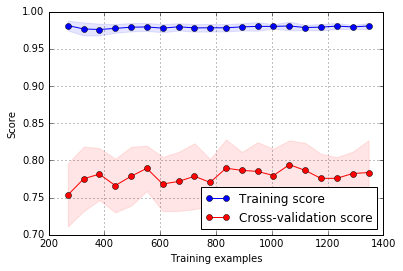

In [28]:
estimator = RandomForestClassifier()    

plot_learning_curve(estimator,X,y_binary)   


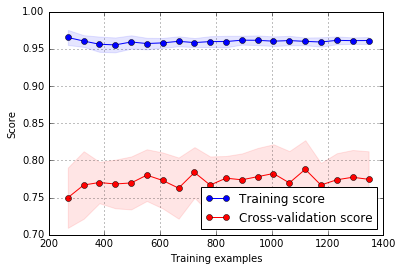

In [68]:
estimator = RandomForestClassifier(n_estimators = 6, max_features = 10)    
plot_learning_curve(estimator,X,y_binary)   

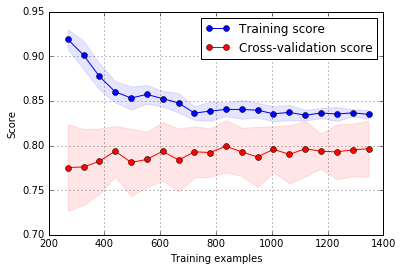

In [59]:
estimator = RandomForestClassifier(max_depth = )    
plot_learning_curve(estimator,X,y_binary)   

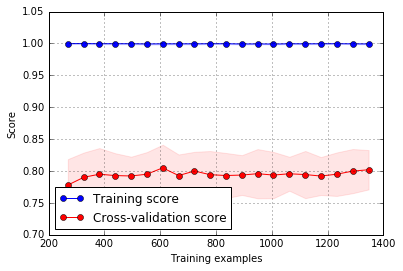

In [66]:
estimator = RandomForestClassifier(n_estimators=50)    
plot_learning_curve(estimator,X,y_binary)  

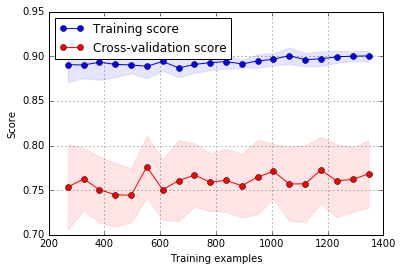

In [67]:
estimator = RandomForestClassifier(n_estimators=2)    
plot_learning_curve(estimator,X,y_binary)   

## 1.2. Multi-Class Classification

### Splitting data into train and test

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_multi, y_test_multi = train_test_split(X,y_multi, test_size=0.3)

In [53]:
# Fit a random forest to the training data for multi-class classification, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 10 )

forest_multi = forest.fit(X_train, y_train_multi)

### Calculating the accuracy of the model

In [54]:
from sklearn import metrics
result_multi_train = forest_multi.predict(X_train)
print(metrics.accuracy_score(y_train_multi, result_multi_train))

0.98690835851


In [55]:
from sklearn import metrics
result_multi_test = forest_multi.predict(X_test)
print(metrics.accuracy_score(y_test_multi, result_multi_test))

0.476525821596


In [56]:
area_under_curve (y_test_multi, result_multi_test)

0.3205128205128205

# 2. Unsupervised Learning

In [70]:
import pandas as pd
import numpy as np
 
crowdstorming_df['skin'] = crowdstorming_df[['rater1', 'rater2']].mean(axis=1)
crowdstorming_df = crowdstorming_df.drop(['rater1', 'rater2'], axis=1)

In [72]:
#df.fillna(df.mean()).dropna(axis=1, how='all')
for _col_name_ in ['height', 'weight','meanIAT','nIAT','seIAT']:
    crowdstorming_df[_col_name_] = crowdstorming_df[_col_name_].fillna(crowdstorming_df[_col_name_].mean())

In [73]:
f = {
    #'club':'first',
    #'birthday':'first',
    'height':'first', 
    'weight':'first',
    'games': 'sum', 
    'victories':'sum',
    'ties': 'sum',
    'defeats': 'sum', 
    'goals': 'sum', 
    'yellowCards': 'sum', 
    'yellowReds': 'sum', 
    'redCards': 'sum',
    #'position':'first',
    #'refNum':'first',
    #'refCountry':'first',
    'meanIAT':'mean',
    'nIAT':'mean', 
    'seIAT':'mean',
    'meanExp': 'mean',
    'nExp':'mean', 
    'seExp':'mean',
    #'rater1':'mean',
    #'rater2':'mean'
    #'skin':'mean',
    'leagueCountry':'first'
}

#df_aggr = df.groupby(['playerShort']).agg(f)
df_grouped = crowdstorming_df.groupby(['playerShort'])

df_skin = df_grouped.agg({'skin': 'mean'})
df_skin['actual_skin'] = np.where(df_skin['skin'] > 0.5, 1,0)

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


scale = StandardScaler()

def sil_score(df_aggr):
    df_aggr_scaled = scale.fit_transform(df_aggr.as_matrix())
    kmeans_model = KMeans(n_clusters=2, random_state=0).fit(df_aggr_scaled)
    labels = kmeans_model.labels_
    return labels, silhouette_score(df_aggr_scaled, labels)

In [75]:
for i in reversed(range(1,len(f.items()))):
    combination = dict(list(f.items())[:i])
    _df_aggregated = df_grouped.agg(dict(combination))
    _df_aggregated = pd.get_dummies(_df_aggregated)
    
    labeled, score = sil_score(_df_aggregated)
    cluster_0 = df_skin[labeled == 0]
    cluster_1 = df_skin[labeled == 1]
    
    print("FIRST CLUSTER: ", cluster_0['skin'].mean(),len(cluster_0))
    print("SCND  CLUSTER: ", cluster_1['skin'].mean(),len(cluster_1))
    
    cluster_0_whites = len(cluster_0[cluster_0['skin'] > 0.5])
    cluster_0_blacks = len(cluster_0[cluster_0['skin'] <= 0.5])
    
    cluster_1_whites = len(cluster_1[cluster_1['skin'] > 0.5])
    cluster_1_blacks = len(cluster_1[cluster_1['skin'] <= 0.5])
    
    print("CLUSTER 0: %d/%d = %%%d" % (cluster_0_whites, len(cluster_0), int(cluster_0_whites/len(cluster_0)*100)))
    print("CLUSTER 1: %d/%d = %%%d" % (cluster_1_whites, len(cluster_1), int(cluster_1_whites/len(cluster_1)*100)))

    
    print(score,_df_aggregated.columns)
    print(score)

('FIRST CLUSTER: ', 0.2981958762886598, 485)
('SCND  CLUSTER: ', 0.2747591006423983, 934)
CLUSTER 0: 80/485 = %16
CLUSTER 1: 147/934 = %15
(0.19402533146620338, Index([u'yellowReds', u'nIAT', u'nExp', u'height', u'victories', u'goals',
       u'ties', u'meanExp', u'weight', u'defeats', u'meanIAT', u'seIAT',
       u'games', u'seExp', u'redCards', u'leagueCountry_England',
       u'leagueCountry_France', u'leagueCountry_Germany',
       u'leagueCountry_Spain'],
      dtype='object'))
0.194025331466
('FIRST CLUSTER: ', 0.29473415132924335, 489)
('SCND  CLUSTER: ', 0.2764784946236559, 930)
CLUSTER 0: 80/489 = %16
CLUSTER 1: 147/930 = %15
(0.19686793277735637, Index([u'weight', u'yellowReds', u'defeats', u'meanIAT', u'nExp', u'height',
       u'victories', u'nIAT', u'seIAT', u'games', u'goals', u'ties',
       u'redCards', u'meanExp', u'leagueCountry_England',
       u'leagueCountry_France', u'leagueCountry_Germany',
       u'leagueCountry_Spain'],
      dtype='object'))
0.196867932777
('F

In [76]:
df_skin

,skin,actual_skin
playerShort,,
aaron-hughes,0.125,0
aaron-hunt,0.125,0
aaron-lennon,0.250,0
aaron-ramsey,0.000,0
abdelhamid-el-kaoutari,0.250,0
abdou-traore_2,0.750,1
abdoulaye-diallo_2,0.875,1
abdoulaye-keita_2,0.875,1
abdoulwhaid-sissoko,1.000,1
